# Tutorial: Fairness-Aware Classification

Fairlearn and AIF360 are the two most prominent Python toolkits for measuring and optimizing for fairness in machine learning. In this tutorial we will explore several post-processing techniques that can be used to advance fairness of a machine learning model.


---

**Learning Objectives**. After this tutorial you will be able to:
* apply techniques for fairness-aware classification in Python;
* examine strengths and limitations of different fairness-aware classification techniques;

---

As a running example, we will use the data set collected by Propublica in their analysis of COMPAS. COMPAS is a decision support tool used by courts in the United States to assess the likelihood of a defendant becoming a recidivist; i.e., relapses into criminal behavior. 

In this tutorial, we will focus on learning a new classifier for predicting recidivism that is optimized for **equalized odds**. This notion of fairness states that false positive rates (FPR) as well as false negatives rates (FNR) should be equal across groups, to avoid *quality-of-service harm*. In the context of pre-trial risk assessment, a false positive prediction can have large consequences for the involved defendant, as they may have to await trial in jail. This may even result in the defendant pleading guilty to a crime they did not commit. On the other extreme, false negatives could mean that dangerous individuals are released into society.



--- 


**WARNING.** *The goal of this tutorial is to showcase technical approaches towards fairness-aware classification. However, we would like to emphasize that especially in a sensitive application such as pre-trial risk assesment, a data scientist's first actions should always include scrutinizing the need for machine learning, the machine learning task formulation, and data collection practices. Moreover, apart from fairness concerns, the accuracy of the models trained in this tutorial are only a bit better than random and they are likely not useful in practice.*

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

# fairlearn
from fairlearn.metrics import false_positive_rate, false_negative_rate
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing import plot_threshold_optimizer

# aif360
from aif360.datasets import StandardDataset
from aif360.algorithms.postprocessing import RejectOptionClassification

pip install 'aif360[AdversarialDebiasing]'


In [2]:
def score(y_train, y_train_pred, y_test, y_test_pred, sensitive_features_train, sensitive_features_test, 
          metric = {'accuracy' : accuracy_score, 'fpr' : false_positive_rate, 'fnr' : false_negative_rate}):
    """
    Helper function to evaluate classifiers without too much repetition of code.
    """
    # train set
    mf_train = MetricFrame(metric = metric, 
                           y_true = y_train,
                           y_pred = y_train_pred, 
                           sensitive_features = sensitive_features_train)
    
    
    # test set
    mf_test = MetricFrame(metric = metric, 
                          y_true = y_test,
                          y_pred = y_test_pred, 
                          sensitive_features = sensitive_features_test)
    
    mf = pd.concat([mf_train.by_group, mf_test.by_group], keys=['train', 'test']).unstack(level=0)
    return mf

### Load and Pre-Process Data

You can download the data set collected by ProPublica [here](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv). As in the previous tutorial, we pre-process the data similar to ProPublica and focus our efforts on Caucasian and African-American defendants.

In [3]:
# load data
df = pd.read_csv('compas-scores-two-years.csv')
# filter similar to propublica
df = df[(df['days_b_screening_arrest'] <= 30) &
                (df['days_b_screening_arrest'] >= -30) &
                (df['is_recid'] != -1) &
                (df['c_charge_degree'] != "O") &
                (df['score_text'] != "N/A")]
# select two largest groups
df = df[(df['race'] == 'African-American') | (df['race'] == 'Caucasian')]

# select columns
df = df[['sex', 'age', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'two_year_recid']]

# convert categorical variables to numerical to make suitable for ML model
df = pd.get_dummies(df, drop_first=True)

#inspect
display(df.head())

# proportion of positives
print("proportion of positives: %.2f" % df['two_year_recid'].mean())

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,two_year_recid,sex_Male,race_Caucasian
1,34,0,0,0,0,1,1,0
2,24,4,0,0,1,1,1,0
6,41,14,0,0,0,1,1,1
8,39,0,0,0,0,0,0,1
10,27,0,0,0,0,0,1,1


proportion of positives: 0.47


The proportion of positives in the data set is almost 0.5, which means that the dataset is balanced in terms of positives/negatives. This makes **accuracy** a suitable metric for measuring the overall predictive performance of our models.

## Classification without Fairness Constraints

First, let's train a simple logistic regression classifier on the data and see how it performs. We first split the data into a training and test set.

**NOTE**. *If we were building a model to be put in production, we would encourage you to use a separate validation and test set. However, for the sake of simplicity, we only consider train and test set in this tutorial.*

In [4]:
# define X and y
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# split the data in train-validation-test sets; use random_state for reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# train simple logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# make predictions
y_train_score_lr = lr.predict_proba(X_train)
y_test_score_lr = lr.predict_proba(X_test)

# make predictions at decision threshold of 0.5
y_train_pred_lr = [1 if i[1] >= 0.5 else 0 for i in y_train_score_lr]
y_test_pred_lr = [1 if i[1] >= 0.5 else 0 for i in y_test_score_lr]

# score
display(score(y_train, y_train_pred_lr, y_test, y_test_pred_lr, X_train['race_Caucasian'], X_test['race_Caucasian']))
print('equalized odds (test): %.2f' % equalized_odds_difference(y_true=y_test, y_pred=y_test_pred_lr, 
                                                                sensitive_features=X_test['race_Caucasian']))
print('accuracy (test): %.2f' % accuracy_score(y_true=y_test, y_pred=y_test_pred_lr))

accuracy                 fpr                fnr          
                   train      test     train     test     train      test
race_Caucasian                                                           
0               0.688547  0.682195  0.313462  0.28903  0.309666  0.345528
1               0.672727  0.674757  0.128035    0.104  0.639033  0.666667

equalized odds (test): 0.32
accuracy (test): 0.68


The test set accuracy of our classifier is approximately the same for African-Americans (0.68) and Caucasians (0.67). However, the FNR and FPR differ substantially, indicating that African-Americans are more often falsely predicted to recidivise, whereas Caucasians are more often falsely predicted to *not* recidivise. This disparity is reflected in the computed equalized odds difference (0.32).


## Manual Post-Processing: Decision Threshold
In our previous model, we have simply applied a standard decision threshold of 0.5 for both African-Americans and Caucasians. One way to account for differences in FPR and FNR is to choose a separate threshold for each sensitive group.

We will now **manually** choose a new decision threshold for African-Americans to ensure that the FPR of African-Americans is equal to the FPR of Caucasians. In our previous model, the FPR in the training set is approximately 0.13 for Caucasians. We use this as our new target FPR for African-Americans. 

In [6]:
# compute new threshold for African-Americans based on **training** data
race_boolean_train = X_train['race_Caucasian'] == 0 # get boolean True : african-american, False : caucasian
y_train_score_lr_A = [i[1] for i, j in zip(y_train_score_lr, race_boolean_train) if j] # get all scores for AA
fpr_A_train, tpr_A_train, thresholds_A_train = roc_curve(y_true=y_train[race_boolean_train], y_score=y_train_score_lr_A)
idx_new_thr = (np.abs(fpr_A_train - 0.13)).argmin() # get index of FPR closest to 0.1
new_thr = thresholds_A_train[idx_new_thr] # get new threshold based on index

print("New decision threshold for African-Americans: %.2f" % new_thr)

New decision threshold for African-Americans: 0.62


Based on the training data, we have computed that a decision threshold of 0.62 would lead to a FPR of approximately 0.13.

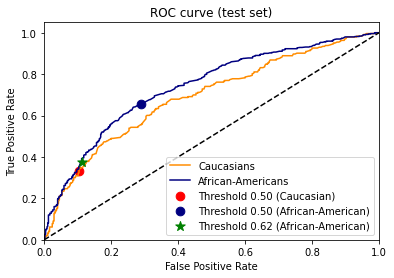

In [7]:
# Compute fpr, tpr, thresholds for **test** data
race_boolean_test = X_test['race_Caucasian'] == 0 # get boolean True : african-american, False : caucasian
# african-Americans
y_test_score_lr_A = [i[1] for i, j in zip(y_test_score_lr, race_boolean_test) if j]
fpr_A_test, tpr_A_test, thresholds_A_test = roc_curve(y_true=y_test[race_boolean_test], y_score=y_test_score_lr_A)
idx_thr_A = (np.abs(thresholds_A_test - 0.5)).argmin() # get index of threshold closest to 0.5
idx_thr_A_new = (np.abs(thresholds_A_test - new_thr)).argmin() # get index of threshold closest to new threshold
# Caucasians
y_test_score_lr_C = [i[1] for i, j in zip(y_test_score_lr, ~race_boolean_test) if j]
fpr_C_test, tpr_C_test, thresholds_C_test = roc_curve(y_true=y_test[~race_boolean_test], y_score=y_test_score_lr_C)
idx_thr_C = (np.abs(thresholds_C_test - 0.5)).argmin() # get index of threshold closest to 0.5

# plot ROC curves
plt.figure()
plt.scatter(fpr_C_test[idx_thr_C], tpr_C_test[idx_thr_C], color='red', label = 'Threshold 0.50 (Caucasian)', s=75)
plt.scatter(fpr_A_test[idx_thr_A], tpr_A_test[idx_thr_A], color='navy', label='Threshold 0.50 (African-American)', s=75)
plt.plot(fpr_C_test, tpr_C_test, color='darkorange', label='Caucasians')
plt.plot(fpr_A_test, tpr_A_test, color='navy', label='African-Americans')
plt.scatter(fpr_A_test[idx_thr_A_new], tpr_A_test[idx_thr_A_new], color='green', 
            label='Threshold %.2f (African-American)' % new_thr,
            marker='*', s=100, zorder=10)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test set)')
plt.legend(loc="lower right")
plt.show()

This plot visualizes the results of our manual selection approach on the test data. We have plotted the ROC curve for each racial group separately. The original decision threshold of 0.5 resulted in higher TPR and FPR for African-Americans. By choosing a different threshold for this group, we end up on a point on the ROC curve that is much closer to the FPR and TPR of Caucasians.

Now let's evaluate the performance of the new decision threshold.

In [8]:
# make new predictions at two separate decision thresholds
y_train_pred_lr_m = [1 if ((score[1] >= 0.5 and not race) or 
                       score[1] >= new_thr and race) else 0 for score, race in zip(y_train_score_lr, race_boolean_train)]
y_test_pred_lr_m = [1 if ((score[1] >= 0.5 and not race) or 
                       score[1] >= new_thr and race) else 0 for score, race in zip(y_test_score_lr, race_boolean_test)]

# score
display(score(y_train, y_train_pred_lr_m, y_test, y_test_pred_lr_m, X_train['race_Caucasian'], X_test['race_Caucasian']))
print('equalized odds (test): %.2f' % equalized_odds_difference(y_true=y_test, y_pred=y_test_pred_lr_m, sensitive_features=X_test['race_Caucasian']))
print('accuracy (test): %.2f' % accuracy_score(y_true=y_test, y_pred=y_test_pred_lr_m))

accuracy                 fpr                 fnr          
                   train      test     train      test     train      test
race_Caucasian                                                            
0               0.622454  0.632505  0.130769  0.111814  0.597092  0.613821
1               0.672727  0.674757  0.128035     0.104  0.639033  0.666667

equalized odds (test): 0.05
accuracy (test): 0.65


As can be seen from this table, we have been able to substantially reduce equalized odds difference (decreased from 0.32 to 0.05), at the cost of some overall accuracy (decreased from 0.68 to 0.65).

## Post-Processing Using Fairlearn's `ThresholdOptimizer`

Another way to post-process predictions of an existing classifier, is by using the `ThresholdOptimizer`. Recall that randomization can be used to create a classifier with **any** predefined FPR/TPR that is either on the line between (0,0) and the classifier's FPR/TPR, or between (1,1) and the classifier's FPR/TPR. 

The `ThresholdOptimizer` algorithm leverages this by randomizing predictions independently for sensitive groups, such that the FPR/TPR is equal. The point on the ROC curve at which randomization is aimed, is optimized such that the disparity is the smallest, while accuracy is the highest.

In Fairlearn, you can choose between optimizing for `'demographic_parity'`, `'equalized odds'`, `'false_positive_rate_parity'` `'false_negative_rate_parity'`, `'true_positive_parity'` and `'true_negative_parity'`. 

Let's see how this algorithm does on our existing logistic regression classifier. 

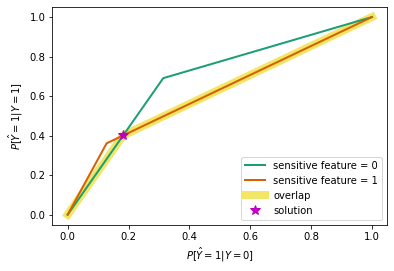

In [9]:
# train thresholdoptimizer
to = ThresholdOptimizer(estimator=lr, constraints='equalized_odds')
to.fit(X_train, y_train, sensitive_features=X_train['race_Caucasian'])

# plot solution
plot_threshold_optimizer(to)

This plot visualizes the solution created by `ThresholdOptimizer`. Each line corresponds to all the possible points in the ROC space that can be achieved through randomization of predictions. Note that the "kink" in each curve corresponds to the ROC curve with a threshold of 0.5. The plotted lines are between these points and (0,0) and (1,1), and represent the space of possible solutions. 

In [10]:
# evaluate
y_train_pred_to = to.predict(X_train, sensitive_features=X_train['race_Caucasian'], random_state=0) # we use random_state for reproducible results 
y_test_pred_to = to.predict(X_test, sensitive_features=X_test['race_Caucasian'], random_state=0)
display(score(y_train, y_train_pred_to, y_test, y_test_pred_to, X_train['race_Caucasian'], X_test['race_Caucasian']))
print('equalized odds (test): %.2f' % equalized_odds_difference(y_true=y_test, y_pred=y_test_pred_to, 
                                                                sensitive_features=X_test['race_Caucasian']))
print('accuracy (test): %.2f' % accuracy_score(y_true=y_test, y_pred=y_test_pred_to))

accuracy                 fpr                 fnr          
                   train      test     train      test     train      test
race_Caucasian                                                            
0               0.597555  0.589027  0.179808  0.175105  0.600513  0.638211
1               0.647811  0.653722  0.188742  0.162667  0.607945   0.62963

equalized odds (test): 0.01
accuracy (test): 0.61


The equalized odds difference is comparable to our manual decision threshold optimization, the accuracy is a bit lower (0.61). Compared to manual optimization of the threshold, the overall FPR is slightly higher whereas the FNR is lower.

## Post-Processing using AIF360's `RejectOptionClassification`

Reject option classification is a post-processing technique that optimizes for fairness in regions for which the classifier is uncertain. The algorithm learns a decision threshold and a margin for that threshold. All instances for which the original classifier's confidence score falls outside of this margin are treated normally. For instances that fall within the decision threshold margin, the output is optimized for fairness.

The algorithm is implemented in AIF360's `RejectOptionClassification` class.

As opposed to Fairlearn, AIF360 requires users to process the dataset using the `StandardDataset` class.

In [11]:
# create training data object
df_train = X_train.copy()
df_train['two_year_recid'] = y_train
dataset_train = StandardDataset(df = df_train, label_name='two_year_recid', favorable_classes=[1], 
                                # because we optimize for equalized odds favorable_classes this does not really matter, but for simplicity we just choose 1
                                protected_attribute_names = ['race_Caucasian'], privileged_classes = [[1]])

# create test dataset object
df_test = X_test.copy()
df_test['two_year_recid'] = y_test
dataset_test = StandardDataset(df = df_test, label_name='two_year_recid', favorable_classes=[1], 
                                # because we optimize for equalized odds favorable_classes this does not really matter, but for simplicity we just choose 1
                                protected_attribute_names = ['race_Caucasian'], privileged_classes = [[1]])

# create training data prediction
dataset_train_pred = dataset_train.copy(deepcopy=True)
dataset_train_pred.scores = y_train_score_lr[:,1].reshape(-1,1)

# create test data prediction
dataset_test_pred = dataset_test.copy(deepcopy=True)
dataset_test_pred.scores = y_test_score_lr[:,1].reshape(-1,1)

In [12]:
# train reject option classifier
rc = RejectOptionClassification(unprivileged_groups=[{'race_Caucasian' : 0}], 
                                privileged_groups=[{'race_Caucasian' : 1}],
                                metric_name='Average odds difference')
rc.fit(dataset_true=dataset_train, dataset_pred=dataset_train_pred)

# print results
print("Classification Threshold: %.2f" % rc.classification_threshold)
print("Margin: %.2f" % rc.ROC_margin)

Classification Threshold: 0.86
Margin: 0.01


In [13]:
# evaluate classifier
y_train_pred_rc = rc.predict(dataset_train_pred).labels 
y_test_pred_rc = rc.predict(dataset_test_pred).labels
display(score(y_train, y_train_pred_rc, y_test, y_test_pred_rc, X_train['race_Caucasian'], X_test['race_Caucasian']))
print('equalized odds (test): %.2f' % equalized_odds_difference(y_true=y_test, y_pred=y_test_pred_rc, sensitive_features=X_test['race_Caucasian']))
print('accuracy (test): %.2f' % accuracy_score(y_true=y_test, y_pred=y_test_pred_rc))

accuracy                   fpr                   fnr          
                   train      test       train        test     train      test
race_Caucasian                                                                
0               0.516976  0.536232   0.0230769   0.0126582  0.892216  0.898374
1               0.622222   0.61165  0.00110375  0.00533333  0.967185  0.979424

equalized odds (test): 0.08
accuracy (test): 0.57


The reject option classifier has the lowest accuracy so far, 0.57. Notably, the false positive rate is close to zero for both Caucasians and African-Americans. This is easily explained by the high classification threshold of 0.86: a defendant is only classified as positive if the classifier is very certain, resulting in a low number of false positives. On the other hand, this policy results in a very high FNR.

## Concluding Remarks
In this tutorial we have showcased several ways in which we can use post-processing to adhere to fairness constraints, either manually or by using one of the algorithms implemented in AIF360 or Fairlearn. 

#### Some Thoughts on the Libraries
* **AIF360.** In this library, a vast amount of mitigation algorithms are implemented. However, the original API and it's dependence on the `Dataset` classes can be tricky to use. However, more recently, a scikit-learn compatible API (with currently limited functionality) has been added to the library as well. The documentation and examples on how to use the library are quite minimal.
* **Fairlearn**. Fairlearn includes much fewer fairness mitigation algorithms than AIF360. The API is more flexible with respect to input data, making it a bit easier to use. The documentation and user guide are more extensive and there is a very active community.

### Discussion Points
* How does post-processing for equalized odds affects other notions of fairness, such as equal calibration and demographic parity? As an exercise, compute fairness metrics that represent alternative notions of (group) fairness. Can you explain the results?
* In this tutorial, we only covered two post-processing algorithms. As an exercise, apply and evaluate one of the other in-processing or post-processing algorithms in either Fairlearn or AIF360. How well does it work?
* Fairness pre-processing algorithms typically optimize for demographic parity, not for equalized odds or equal calibration. Can you explain why?
* Our manual choice of the decision threshold uses a different decision threshold for African-Americans than for Caucasins. Under which circumstances would you deem such a policy fair, if any? Why?
* The post-processing algorithm implemented in `ThresholdOptimizer` uses randomization in order to achieve equalized odds. Consequently, individuals with the exact same characteristics may receive a different prediction. Under which circumstances would you deem such a policy fair, if any? Why?
